In [2]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# Vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
#s = tuple(enumerate(chars))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [6]:
# Build the dataset
block_size = 3 # Context length: how many characters do we take to predict the next one.
def build_dataset(words):
    x, y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            #print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]
    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape, y.shape)
    return x, y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

xtr, ytr = build_dataset(words[:n1])
xdev, ydev = build_dataset(words[n1:n2])
xte, yte = build_dataset(words[n2:])



torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [12]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
c = torch.randn((27, 10), generator=g)
w1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
w2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [c, w1, b1, w2, b2]

In [13]:
s = (p.nelement() for p in parameters)
sum(s)

11897

In [14]:
for p in parameters:
    p.requires_grad = True

In [15]:
lre = torch.linspace(-3, 0, 10000) # Learning rate exponent
lrs = 10**lre 
lrs

tensor([0.0010, 0.0010, 0.0010,  ..., 0.9986, 0.9993, 1.0000])

In [16]:
# Training Split, Dev/Validation Split, Test Split
 #80%, 10%, 10%

In [17]:
lri = []
lossi = []
stepsi = []

In [37]:
# Mini batch example - Randomly use the input

for i in range(200000):
    
    # Mini batch construct
    ix = torch.randint(0, xtr.shape[0], (32,))
    
    #Forward Pass

    emb = c[xtr[ix]]    #emb.shape #-- [32, 3, 2]
    h = torch.tanh(emb.view(-1, 30) @ w1 + b1)       #h.shape #--[32, 100]
    logits = h @ w2 + b2       #logits.shape # -- [32, 27]

    # counts = logits.exp()
    # prob = counts/counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), y].log().mean()

    # Alternative to above 3 lines.
    loss = F.cross_entropy(logits, ytr[ix])
    #print(loss.item())

    #Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    #lr = lrs[i]
    lr = 0.1 if i< 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    lri.append(lr)
    stepsi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

2.0539212226867676


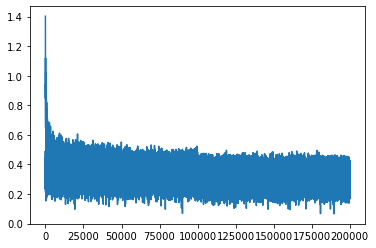

In [38]:
plt.plot(stepsi, lossi)

In [39]:
emb = c[xtr]    #emb.shape #-- [32, 3, 2]
h = torch.tanh(emb.view(-1, 30) @ w1 + b1)       #h.shape #--[32, 100]
logits = h @ w2 + b2       #logits.shape # -- [32, 27]

loss = F.cross_entropy(logits, ytr)
loss

tensor(2.0603, grad_fn=<NllLossBackward0>)

In [40]:
emb = c[xdev]    #emb.shape #-- [32, 3, 2]
h = torch.tanh(emb.view(-1, 30) @ w1 + b1)       #h.shape #--[32, 100]
logits = h @ w2 + b2       #logits.shape # -- [32, 27]

loss = F.cross_entropy(logits, ydev)
loss

tensor(2.1274, grad_fn=<NllLossBackward0>)

In [41]:
emb = c[xte]    #emb.shape #-- [32, 3, 2]
h = torch.tanh(emb.view(-1, 30) @ w1 + b1)       #h.shape #--[32, 100]
logits = h @ w2 + b2       #logits.shape # -- [32, 27]

loss = F.cross_entropy(logits, yte)
loss

tensor(2.1249, grad_fn=<NllLossBackward0>)

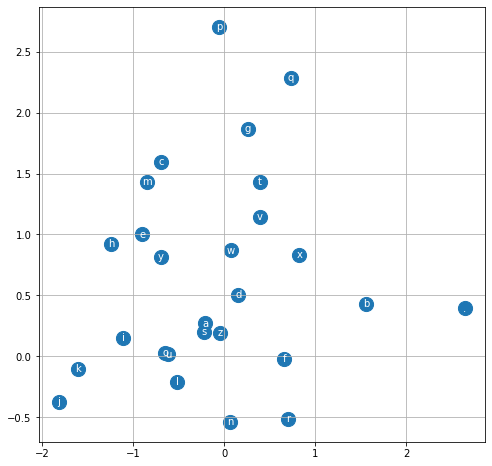

In [42]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(c[:,0].data, c[:,1].data, s=200)
for i in range(c.shape[0]):
    plt.text(c[i,0].item(), c[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [44]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = c[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ w1 + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

eria.
amyah.
see.
mel.
ryllo.
everstendraega.
zered.
eliah.
miloparekeison.
anar.
elle.
malaia.
nosalexzi.
hira.
jakin.
renleigh.
berlyn.
brence.
ryyah.
faeha.
